In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
ROOT = Path(".")
INPUT_PATH = ROOT / "data/processed/movies_clean.csv"
ANALYSIS_DIR = ROOT / "data/processed/analysis_results"

FIG_DIR = ROOT / "results/figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(INPUT_PATH)

df["budget"] = pd.to_numeric(df["budget"], errors="coerce")
df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce")
df = df.dropna(subset=["budget", "revenue"])
df = df[df["budget"] > 0].copy()
df["roi"] = df["revenue"] / df["budget"]

#print("Figures ->", FIG_DIR.resolve())
df.shape

(499, 18)

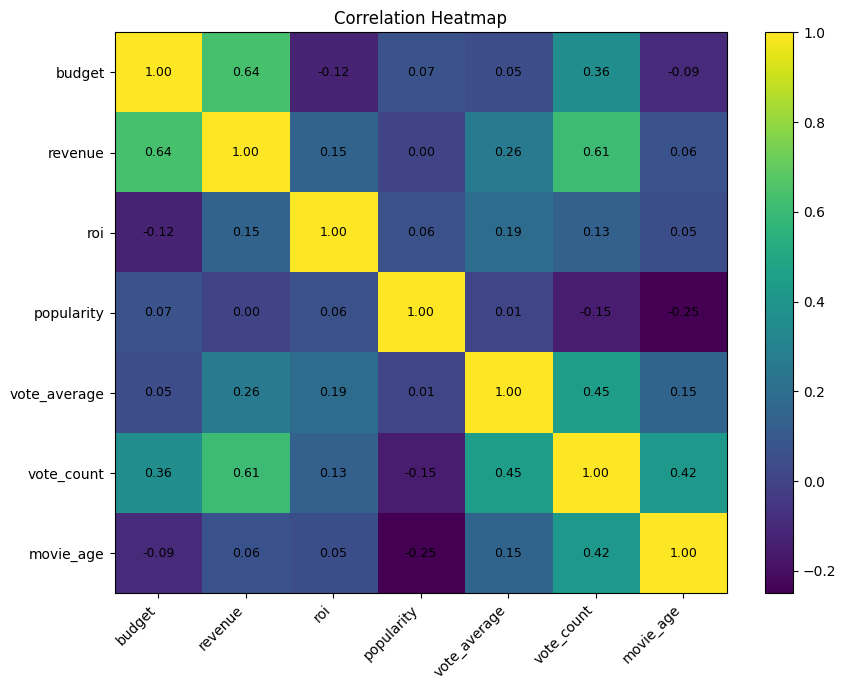

In [3]:
corr_cols = ["budget", "revenue", "roi", "popularity", "vote_average", "vote_count", "movie_age"]
corr = df[corr_cols].corr(numeric_only=True)

plt.figure(figsize=(9, 7))
im = plt.imshow(corr.values, aspect="auto")
plt.title("Correlation Heatmap")
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha="right")
plt.yticks(range(len(corr_cols)), corr_cols)
plt.colorbar(im)

# annotate each cell with value
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        plt.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center", fontsize=9)

plt.tight_layout()
plt.savefig(FIG_DIR / "correlation_heatmap.png", dpi=200)
plt.show()

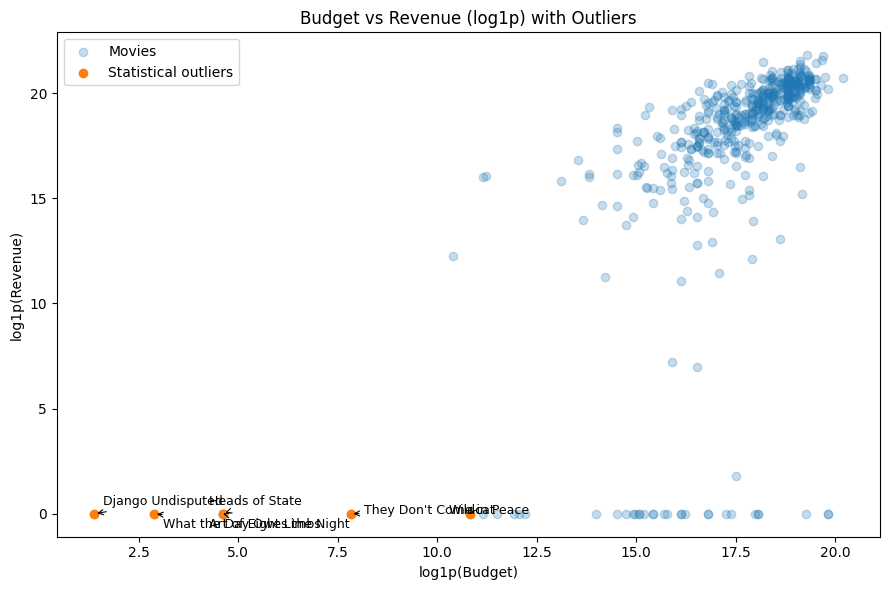

In [4]:
# log scatter (FORCE pandas Series)
x = np.log1p(pd.to_numeric(df["budget"], errors="coerce"))
y = np.log1p(pd.to_numeric(df["revenue"], errors="coerce"))

# z-score distance for outliers
zx = (x - x.mean()) / x.std(ddof=0)
zy = (y - y.mean()) / y.std(ddof=0)
dist = np.sqrt(zx**2 + zy**2)

# pick top N outliers
N = 6
out_idx = dist.nlargest(N).index

# offsets to avoid label overlap
offsets = [
    (6, 6), (6, -10), (-10, 6), (-10, -10),
    (10, 0), (-15, 0)
]

plt.figure(figsize=(9, 6))
plt.scatter(x, y, alpha=0.25, label="Movies")

# highlight outliers
plt.scatter(x.loc[out_idx], y.loc[out_idx], alpha=1.0, label="Statistical outliers")

# annotate with staggered offsets + arrows
for k, i in enumerate(out_idx):
    label = df.loc[i, "title"] if "title" in df.columns else str(i)
    dx, dy = offsets[k % len(offsets)]
    plt.annotate(
        label,
        (x.loc[i], y.loc[i]),
        textcoords="offset points",
        xytext=(dx, dy),
        fontsize=9,
        arrowprops=dict(arrowstyle="->", linewidth=0.8)
    )

plt.title("Budget vs Revenue (log1p) with Outliers")
plt.xlabel("log1p(Budget)")
plt.ylabel("log1p(Revenue)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "budget_vs_revenue_outliers.png", dpi=200)
plt.show()

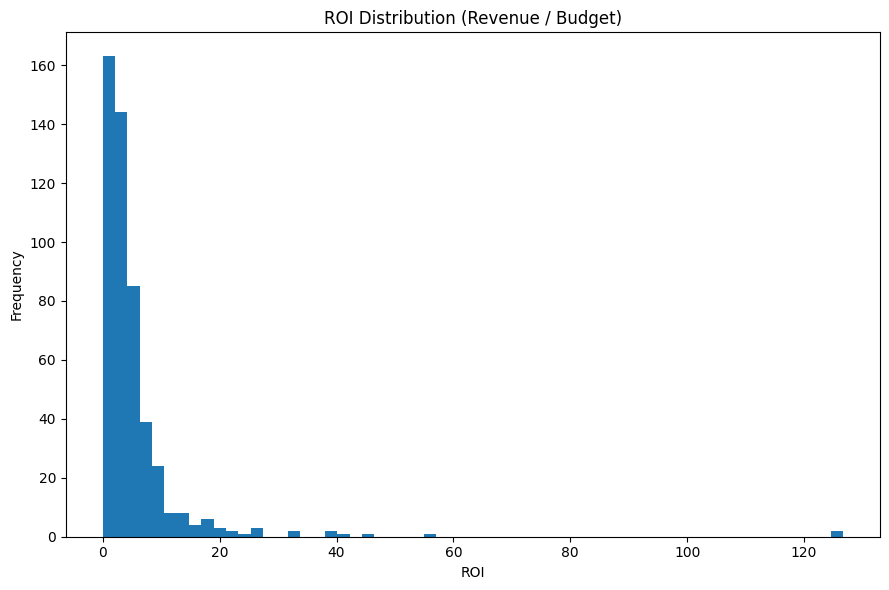

In [5]:
plt.figure(figsize=(9, 6))
roi = df["roi"].replace([np.inf, -np.inf], np.nan).dropna()
plt.hist(roi, bins=60)
plt.title("ROI Distribution (Revenue / Budget)")
plt.xlabel("ROI")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(FIG_DIR / "roi_distribution.png", dpi=200)
plt.show()

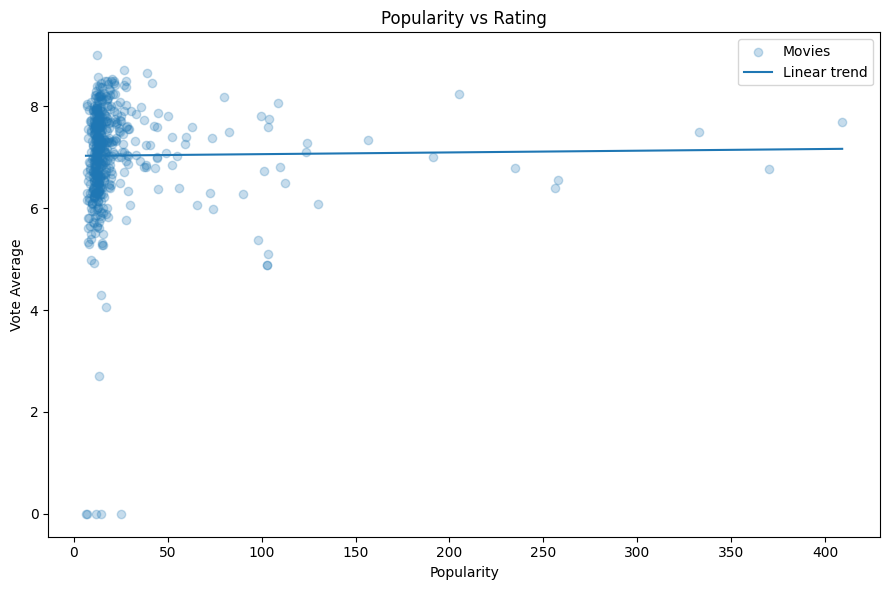

In [6]:
pop = pd.to_numeric(df["popularity"], errors="coerce")
rate = pd.to_numeric(df["vote_average"], errors="coerce")
mask = pop.notna() & rate.notna()

x = pop[mask].values
y = rate[mask].values

plt.figure(figsize=(9, 6))

plt.scatter(x, y, alpha=0.25, label="Movies")

# linear trend
coef = np.polyfit(x, y, 1)
xx = np.linspace(x.min(), x.max(), 200)
yy = coef[0] * xx + coef[1]
plt.plot(xx, yy, label="Linear trend")

plt.title("Popularity vs Rating")
plt.xlabel("Popularity")
plt.ylabel("Vote Average")
plt.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "popularity_vs_rating_trend.png", dpi=200)
plt.show()

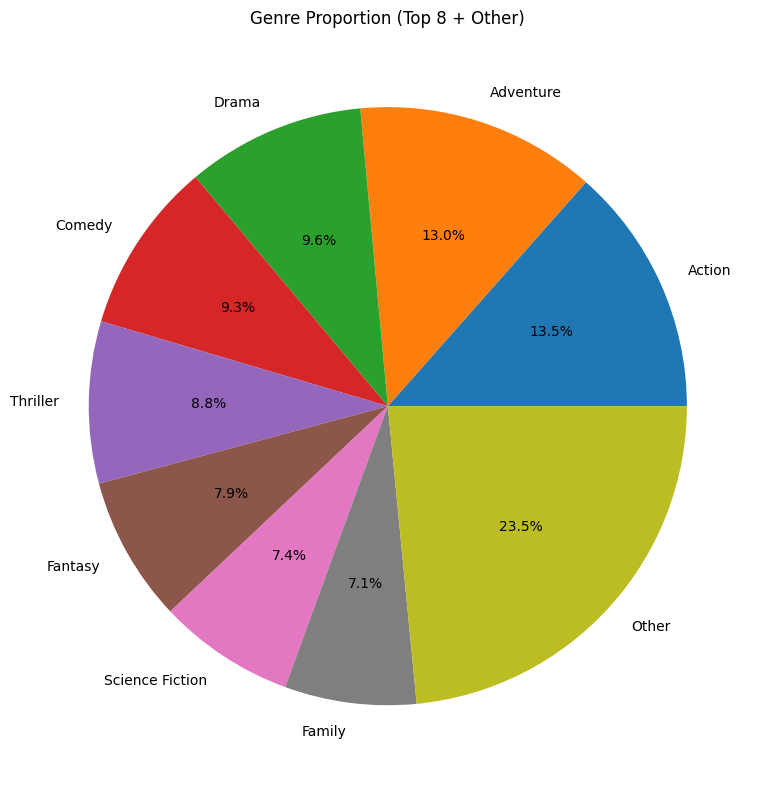

In [7]:
if "all_genres" in df.columns:
    genres = df["all_genres"].dropna().astype(str).str.split("|")
    genre_counts = genres.explode().value_counts()

    top_k = 8
    top = genre_counts.head(top_k)
    other = pd.Series({"Other": genre_counts.iloc[top_k:].sum()})
    plot_counts = pd.concat([top, other])

    plt.figure(figsize=(8, 8))
    plt.pie(
        plot_counts.values,
        labels=plot_counts.index,
        autopct=lambda p: f"{p:.1f}%"
    )
    plt.title(f"Genre Proportion (Top {top_k} + Other)")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "genre_proportion_pie.png", dpi=200)
    plt.show()
else:
    print("No all_genres column.")


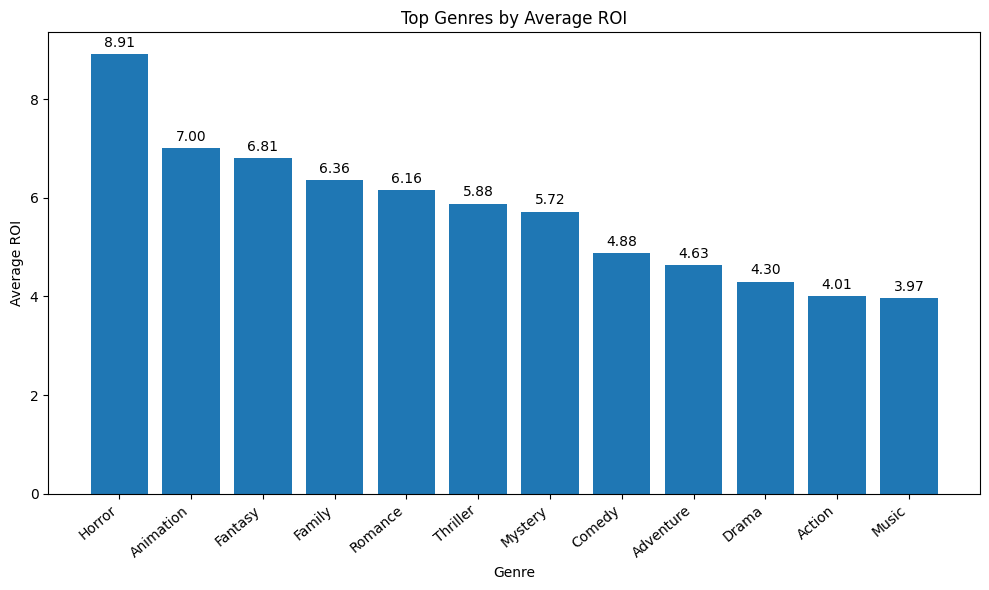

In [8]:
genre_roi_path = ANALYSIS_DIR / "genre_roi.csv"
if genre_roi_path.exists():
    genre_roi = pd.read_csv(genre_roi_path).head(12)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(genre_roi["genre"], genre_roi["avg_roi"])
    plt.title("Top Genres by Average ROI")
    plt.xlabel("Genre")
    plt.ylabel("Average ROI")
    plt.xticks(rotation=40, ha="right")

    plt.bar_label(bars, fmt="%.2f", padding=3)

    plt.tight_layout()
    plt.savefig(FIG_DIR / "top_genres_by_roi_labeled.png", dpi=200)
    plt.show()
else:
    print("genre_roi.csv not found — run analysis first.")

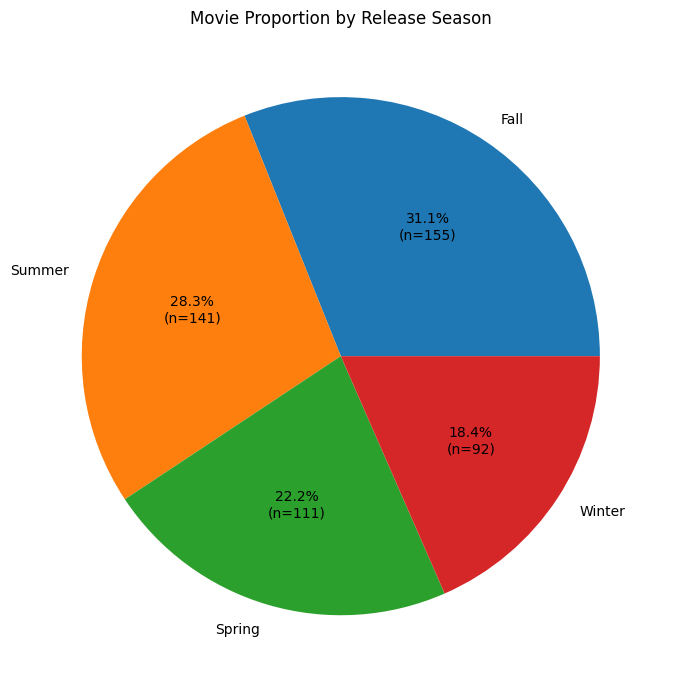

In [9]:
if "release_season" in df.columns:
    season_counts = df["release_season"].value_counts(dropna=True)

    plt.figure(figsize=(7, 7))
    plt.pie(
        season_counts.values,
        labels=season_counts.index,
        autopct=lambda p: f"{p:.1f}%\n(n={int(round(p/100*season_counts.sum()))})"
    )
    plt.title("Movie Proportion by Release Season")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "season_proportion_pie.png", dpi=200)
    plt.show()
else:
    print("No release_season column.")


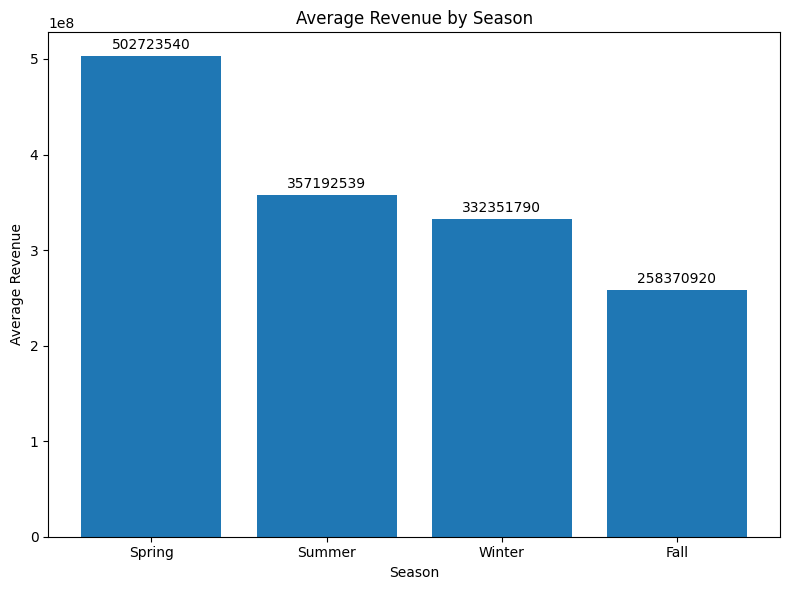

In [10]:
season_path = ANALYSIS_DIR / "season_stats.csv"
if season_path.exists():
    season = pd.read_csv(season_path)

    plt.figure(figsize=(8, 6))
    bars = plt.bar(season["release_season"], season["avg_revenue"])
    plt.title("Average Revenue by Season")
    plt.xlabel("Season")
    plt.ylabel("Average Revenue")

    plt.bar_label(bars, fmt="%.0f", padding=3)

    plt.tight_layout()
    plt.savefig(FIG_DIR / "avg_revenue_by_season_labeled.png", dpi=200)
    plt.show()


/var/folders/p_/pf1mg4h55svbf3k76n3j1nch0000gn/T/ipykernel_28294/630489614.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=labels, showfliers=True)


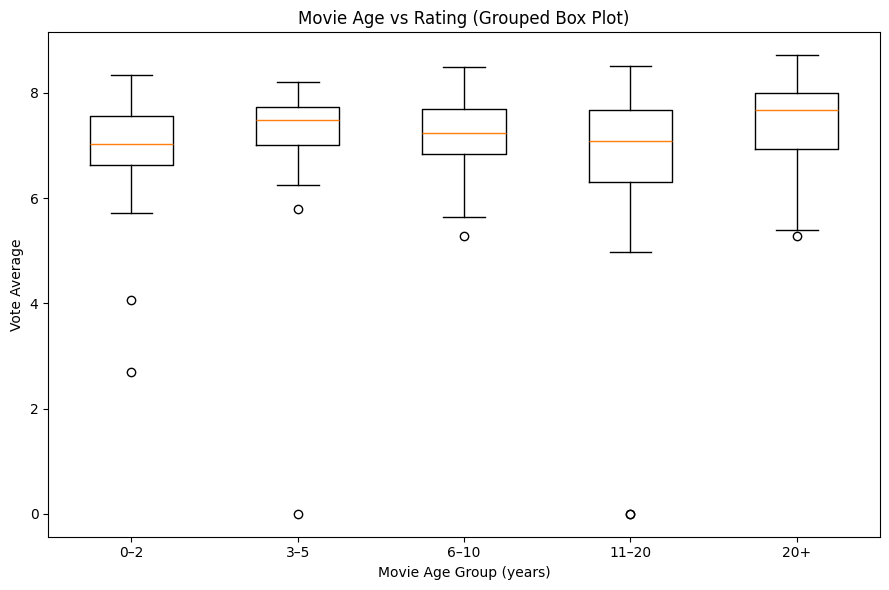

In [11]:
# create age bins
bins = [0, 2, 5, 10, 20, 40]
labels = ["0–2", "3–5", "6–10", "11–20", "20+"]

df["age_group"] = pd.cut(df["movie_age"], bins=bins, labels=labels, right=True)

# prepare data for boxplot
box_data = [
    df.loc[df["age_group"] == g, "vote_average"].dropna()
    for g in labels
]

plt.figure(figsize=(9, 6))
plt.boxplot(box_data, labels=labels, showfliers=True)
plt.title("Movie Age vs Rating (Grouped Box Plot)")
plt.xlabel("Movie Age Group (years)")
plt.ylabel("Vote Average")
plt.tight_layout()
plt.savefig(FIG_DIR / "Age_vs_rating_boxplot.png", dpi=200)
plt.show()


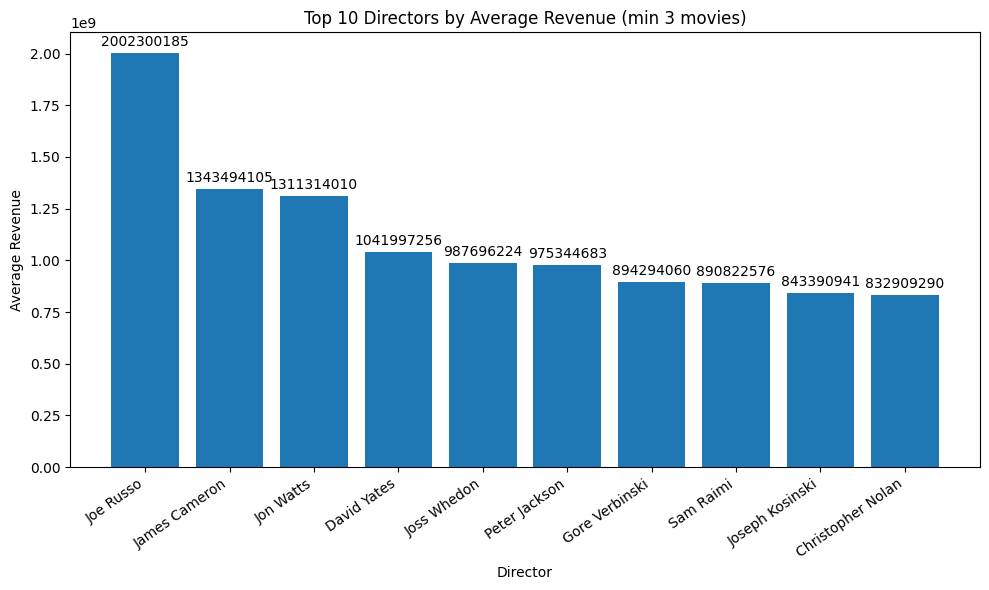

In [12]:
if "director_name" in df.columns:
    director_stats = (
        df.groupby("director_name")
          .agg(
              avg_revenue=("revenue", "mean"),
              n_movies=("revenue", "size")
          )
          .query("n_movies >= 3")   # avoid one-hit noise
          .sort_values("avg_revenue", ascending=False)
          .head(10)
          .reset_index()
    )

    plt.figure(figsize=(10, 6))
    bars = plt.bar(director_stats["director_name"], director_stats["avg_revenue"])
    plt.title("Top 10 Directors by Average Revenue (min 3 movies)")
    plt.xlabel("Director")
    plt.ylabel("Average Revenue")
    plt.xticks(rotation=35, ha="right")

    plt.bar_label(bars, fmt="%.0f", padding=3)

    plt.tight_layout()
    plt.savefig(FIG_DIR / "top_directors_avg_revenue.png", dpi=200)
    plt.show()

/var/folders/p_/pf1mg4h55svbf3k76n3j1nch0000gn/T/ipykernel_28294/2054468424.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=top_directors, showfliers=True)


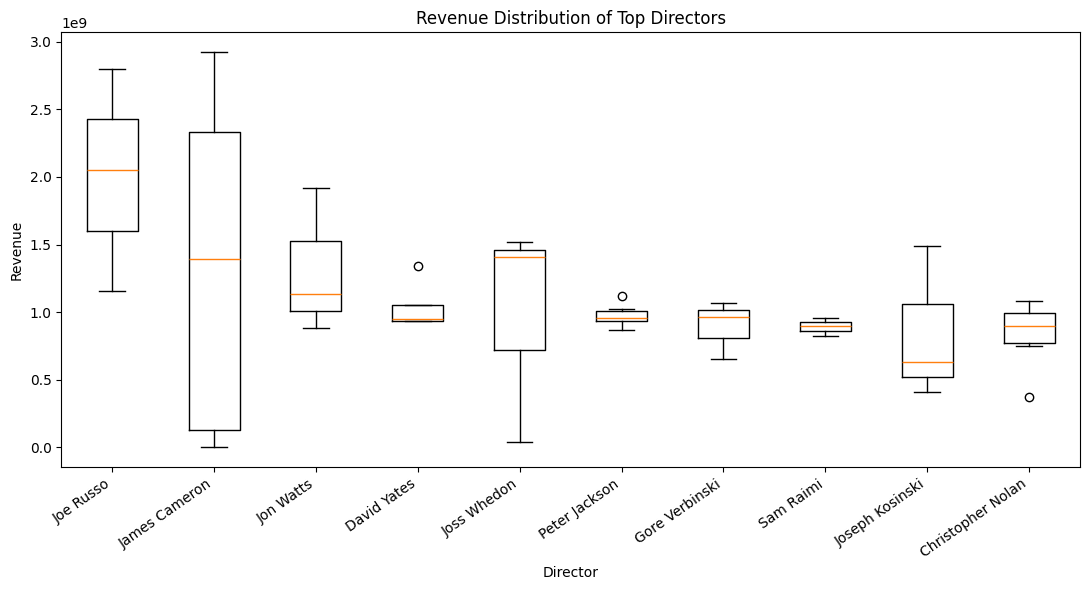

In [13]:
top_directors = director_stats["director_name"]

data = [
    df.loc[df["director_name"] == d, "revenue"].values
    for d in top_directors
]

plt.figure(figsize=(11, 6))
plt.boxplot(data, labels=top_directors, showfliers=True)
plt.title("Revenue Distribution of Top Directors")
plt.xlabel("Director")
plt.ylabel("Revenue")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.savefig(FIG_DIR / "Director_revenue_boxplot.png", dpi=200)
plt.show()


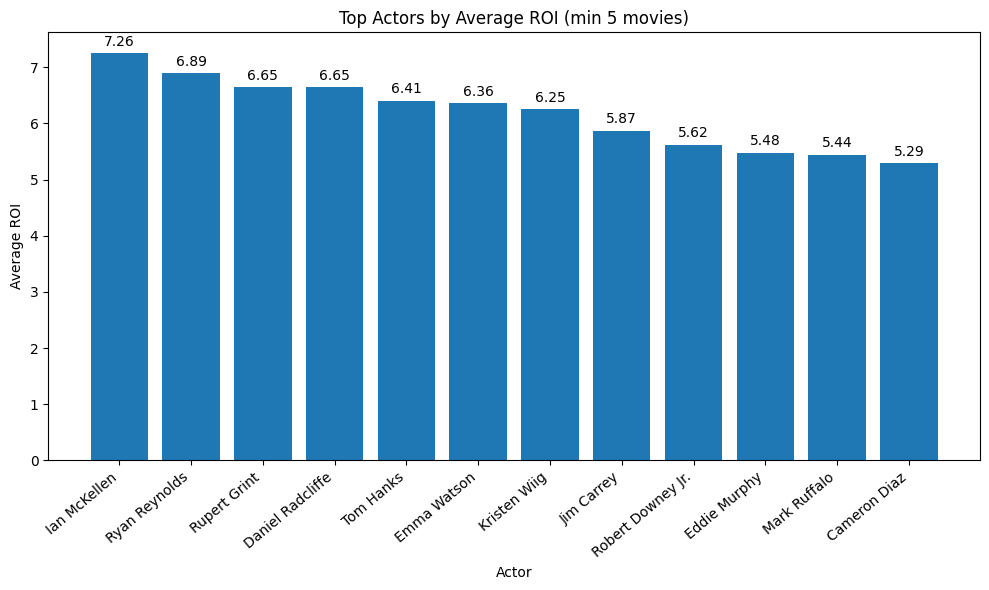

In [14]:
if "top_3_cast" in df.columns:
    tmp = df.copy()
    tmp["actor_list"] = tmp["top_3_cast"].astype(str).str.split("|")
    exploded = tmp.explode("actor_list")

    actor_stats = (
        exploded.groupby("actor_list")
        .agg(
            avg_roi=("roi", "mean"),
            n_movies=("roi", "size")
        )
        .query("n_movies >= 5")
        .sort_values("avg_roi", ascending=False)
        .head(12)
        .reset_index()
        .rename(columns={"actor_list": "actor"})
    )

    plt.figure(figsize=(10, 6))
    bars = plt.bar(actor_stats["actor"], actor_stats["avg_roi"])
    plt.title("Top Actors by Average ROI (min 5 movies)")
    plt.xlabel("Actor")
    plt.ylabel("Average ROI")
    plt.xticks(rotation=40, ha="right")

    plt.bar_label(bars, fmt="%.2f", padding=3)

    plt.tight_layout()
    plt.savefig(FIG_DIR / "top_actors_avg_roi.png", dpi=200)
    plt.show()


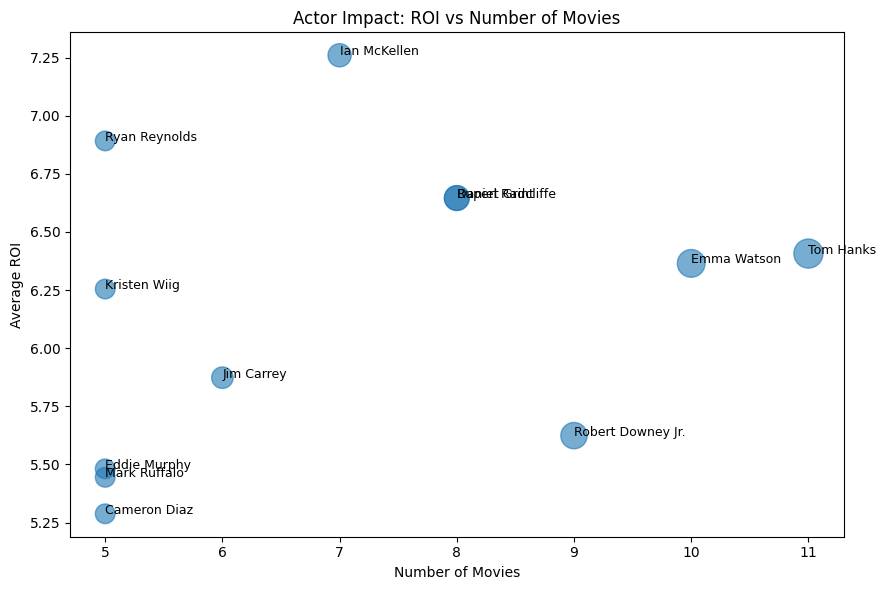

In [15]:
plt.figure(figsize=(9, 6))
plt.scatter(
    actor_stats["n_movies"],
    actor_stats["avg_roi"],
    s=actor_stats["n_movies"] * 40,
    alpha=0.6
)

for _, r in actor_stats.iterrows():
    plt.text(r["n_movies"], r["avg_roi"], r["actor"], fontsize=9)

plt.title("Actor Impact: ROI vs Number of Movies")
plt.xlabel("Number of Movies")
plt.ylabel("Average ROI")
plt.tight_layout()
plt.savefig(FIG_DIR / "Actor_roi_vs_count.png", dpi=200)
plt.show()

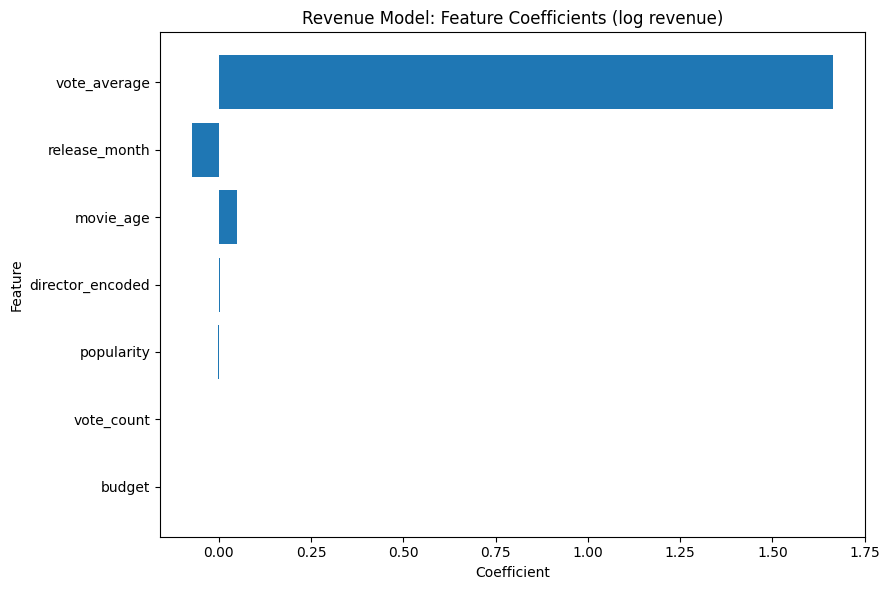

In [16]:
fi_path = ANALYSIS_DIR / "feature_importance.csv"
if fi_path.exists():
    fi = pd.read_csv(fi_path).sort_values("abs_coefficient", ascending=True)

    plt.figure(figsize=(9, 6))
    plt.barh(fi["feature"], fi["coefficient"])
    plt.title("Revenue Model: Feature Coefficients (log revenue)")
    plt.xlabel("Coefficient")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "feature_importance.png", dpi=200)
    plt.show()
else:
    print("feature_importance.csv not found — run run_analysis.ipynb first.")